In [ ]:
import os


os.environ['GOOGLE_API_KEY']   #

In [ ]:
import json


In [ ]:
!pip install google-generativeai pandas python-dotenv

In [ ]:
import pandas as pd

# Create dummy customer information for the same trip
data = {
    "Customer_ID": [1, 2],
    "Customer_Name": ["Alice Johnson", "Bob Smith"],
    "Age": [12, 70],
    "Gender": ["Female", "Male"],
    "Extras":["Smooth Adventurous Picnic", "Should Animals"],
    "Destination": ["Paris, France"] * 2,  # Same destination for all
    "Travel_Dates": ["2024-01-15 to 2024-01-20"] * 2,  # Same travel dates for all
    "Total_Days" : [2 for i in range(2)],
    "Themes": ["Romantic"] * 2,  # Same theme for all
    "Special_Activities": [
        "Eiffel Tower dinner, Seine river cruise",  # Shared itinerary
        "Eiffel Tower dinner, Seine river cruise",
    ]
}
# Create a DataFrame
customer_df = pd.DataFrame(data)

# Display the DataFrame
print(customer_df)

   Customer_ID  Customer_Name  Age  Gender                     Extras  \
0            1  Alice Johnson   12  Female  Smooth Adventurous Picnic   
1            2      Bob Smith   70    Male             Should Animals   

     Destination              Travel_Dates  Total_Days    Themes  \
0  Paris, France  2024-01-15 to 2024-01-20           2  Romantic   
1  Paris, France  2024-01-15 to 2024-01-20           2  Romantic   

                        Special_Activities  
0  Eiffel Tower dinner, Seine river cruise  
1  Eiffel Tower dinner, Seine river cruise  


In [ ]:
itinerary = {
    "Day_1" : "Evening cruise on the Seine",
    "Day_2" : "Sunset at Montmartre",
}

In [ ]:
import google.generativeai as genai

def configure_genai(api_key_var_name='GOOGLE_API_KEY', model_name="gemini-1.5-flash", generation_config=None):
    """
    Configures the Generative AI model with API key and settings.
    """
    api_key = os.environ.get(api_key_var_name)

    if not api_key:
        raise ValueError(f"API key not found in environment variable: {api_key_var_name}")

    genai.configure(api_key=api_key)

    if not generation_config:
        generation_config = {
            "temperature": 0.4, # Controls the randomness of the generated output. Lower values (e.g., 0.1) make the output more deterministic, while higher values (e.g., 1.0) make it more random.
            "top_p": 0.95,# Determines the cumulative probability of the smallest set of top tokens to consider. This is known as "nucleus sampling". A value of 0.95 means the model will consider the smallest set of tokens that cumulatively sum to 95% probability.
            "top_k": 36, # Limits the number of highest probability tokens to sample from. If set to 36, the model will only consider the top 36 tokens at each generation step.
            "max_output_tokens": 8192,# Sets the maximum number of tokens that can be generated. This defines how long the model's output can be, in terms of tokens (words, characters, etc.).
            "response_mime_type": "text/plain", # Specifies the MIME type of the generated response. "text/plain" indicates plain text, which is typical for text generation.
        }

    return genai.GenerativeModel(model_name=model_name, generation_config=generation_config)


In [ ]:
def generate_prompt(customer, itinerary):
    """
    Generate a prompt for a specific customer and itinerary.

    Args:
        customer (dict): Customer details as a dictionary.
        itinerary (dict): The trip itinerary.

    Returns:
        str: Generated prompt for the customer.
    """
    return f"""

You are tasked with generating personalized prompts to be passed to an image generation model. These prompts must vividly and *photographically* describe engaging scenes for each day of a customer's trip, crafted uniquely to their preferences, age, gender, and trip details.

### Requirements:
1. **Deep Personalization**:
   - Tailor the prompts to reflect the customer's age, gender, and preferences. Incorporate their extra requirements seamlessly into the visual scene descriptions.
   - Avoid making people the main highlights of the scene; instead, focus on environmental and contextual elements that align with the customer's details.
   - Reflect the trip's theme (e.g., romantic, adventurous) by enhancing the atmosphere, colors, and mood of the scene.
   - Include unique, personalized elements in each scene to ensure the itinerary feels custom-made for the customer.

2. **Photographic Realism**:
   - Write prompts as if describing a high-quality photo. Use terms like:
     - “A high-resolution photo of...”
     - “Shot with a 35mm lens, ultra photorealistic, DSLR quality”
     - “Golden hour lighting, cinematic, soft shadows, natural light”
   - Style should evoke real-life photography and avoid cartoonish, animated, or illustrated aesthetics.
   - Use language that helps generate hyper-realistic images with photographic fidelity.

3. **Enhanced Visual Descriptions**:
   - Use detailed and vivid language to bring the scene to life. Include elements like time of day, weather, ambiance, and cultural aspects specific to the destination.
   - Incorporate iconic landmarks and unique features of the destination to create a captivating and realistic image for the customer.
   - Ensure each prompt paints a photo-like moment.

4. **Base Itinerary Integration**:
   - Utilize the provided itinerary to guide the main activities for each day of the trip.
   - Expand on these activities with detailed, location-specific descriptions that make each scene visually compelling and photographically accurate.

5. **Formatting and Output**:
   - Generate prompts for all days of the trip for each customer.
   - Structure the output as a JSON object containing the following keys:
     - `CustomerName`: The full name of the customer.
     - `CustomerID`: The unique identifier for the customer.
     - `Prompts`: A dictionary containing prompts for each day of the trip, with keys `Day_1`, `Day_2`, etc.
   - Ensure all keys start with a capital letter.
   - Limit each prompt to **220 characters or fewer**.

### Inputs:
- **Customer Information**:
  - Name: {customer['Customer_Name']}
  - Age: {customer['Age']}
  - Gender: {customer['Gender']}
  - Extra requirements: {customer['Extras']}
  - Destination: {customer['Destination']}
  - Theme: {customer['Themes']}
  - Special Activities: {customer['Special_Activities']}
- **Base Itinerary**:
  {itinerary}

### Schema:

- CustomerName
- CustomerID
- Prompts
  - Day_1
  - Day_2
  - ...

### Expectations:
- Ensure each prompt feels like a description of a real-life photo.
- Add relevant photographic terms to elevate realism.
- Use vivid but concise language to fit within the 220-character limit.
- Return the output as a JSON object, strictly following the schema, with no extra commentary.

"""

In [ ]:
def store_llm_response(response_data, file_path='final_response.json'):
    """
    Stores LLM response data into a JSON file.

    Args:
        response_data (str): The raw response string from the model.
        file_path (str): Path to the JSON file where the response is stored.

    Returns:
        None
    """
    try:
        if response_data.startswith("```json"):
            response_data = response_data[7:].strip()
        if response_data.endswith("```"):
            response_data = response_data[:-3].strip()

        if not response_data.strip():
            print("The response is empty.")
            return

        try:
            parsed_data = json.loads(response_data)
        except json.JSONDecodeError:
            print("Invalid JSON response. Raw response:")
            print(response_data)
            return

        if os.path.exists(file_path):
            with open(file_path, 'r') as json_file:
                existing_data = json.load(json_file)
        else:
            existing_data = {}

        if 'responses' not in existing_data:
            existing_data['responses'] = []

        existing_data['responses'].append(parsed_data)

        with open(file_path, 'w') as json_file:
            json.dump(existing_data, json_file, indent=4)

        print(f"Response successfully saved to {file_path}")

    except Exception as e:
        print(f"Error while saving response: {e}")


In [ ]:
def personalized_prompts(customer_df, itinerary):
    # Step 1: Configure the Generative AI model
    model = configure_genai()

    # Step 2: Iterate over each customer in the DataFrame
    for _, customer in customer_df.iterrows():
        # Convert customer row to dictionary
        customer_data = customer.to_dict()

        # Generate the prompt for the current customer
        prompt = generate_prompt(customer_data, itinerary)

        # Step 3: Generate the content using the model
        response = model.generate_content(prompt)
        response_text = response.text

        # Step 4: Store the response
        store_llm_response(response_text)

        print(f"Response for {customer_data['Customer_Name']} saved.")

if __name__ == "__main__":
    personalized_prompts(customer_df, itinerary)


Response successfully saved to final_response.json
Response for Alice Johnson saved.
Response successfully saved to final_response.json
Response for Bob Smith saved.


In [ ]:
def load_json(file_path):
  try:
    with open(file_path, 'r') as file:
      return json.load(file)
  except Exception as e:
    print(f"Error loading JSON file: {e}")
    return None

In [ ]:
import json

def load_json(file_path):
    """
    Load JSON data from a file.

    Args:
        file_path (str): Path to the JSON file.

    Returns:
        dict: Parsed JSON data.
    """
    try:
        with open(file_path, 'r') as file:
            return json.load(file)
    except Exception as e:
        print(f"Error loading JSON file: {e}")
        return None




In [ ]:
def extract_prompts(json_data, total_days):
    """
    Extract prompts for each day for all customers in the JSON data.

    Args:
        json_data (dict): The JSON data containing responses.
        total_days (int): Number of days in the itinerary.

    Returns:
        list: List of prompts for all days for all customers.
    """
    prompts_array = []

    try:
        for response in json_data.get('responses', []):
            for day in range(total_days):
                day_key = f"Day_{day + 1}"
                if day_key in response.get('Prompts', {}):
                    prompts_array.append(response['Prompts'][day_key])
                else:
                    print(f"Day key '{day_key}' not found in response.")
    except Exception as e:
        print(f"Error extracting prompts: {e}")

    return prompts_array


In [ ]:
def storing_prompts_in_array(file_path = 'final_response.json',total_days = customer_df["Total_Days"][0]):
    """
    Main function to load JSON data and extract prompts.

    Returns:
        None
    """

    # Load JSON data
    json_data = load_json(file_path)

    if not json_data:
        print("Failed to load JSON data.")
        return

    # Extract prompts
    prompts_array = extract_prompts(json_data, total_days)

    # Print the extracted prompts
    print("Extracted Prompts:", prompts_array)
    return prompts_array

if __name__ == "__main__":
    prompt_array = storing_prompts_in_array(file_path = 'final_response.json')


Extracted Prompts: ['Romantic Seine River cruise at sunset, Parisian lights reflecting on the water, smooth gentle waves, a picnic basket with delicious treats.', 'Golden hour sunlight illuminating Montmartre, charming Parisian architecture, a smooth, grassy hill perfect for a picnic, vibrant sunset colors.', 'Romantic Parisian sunset, Seine River cruise, gentle waves reflecting city lights, a lone swan gliding by, Eiffel Tower shimmering in the distance.', 'Golden hour light on Montmartre, charming street scene,  a friendly dog resting near a cafe,  artists painting, Sacré-Cœur Basilica in the background.', 'A high-resolution photo of a Seine River cruise at sunset, Parisian lights twinkling, soft golden hour lighting, romantic atmosphere, shot with a 35mm lens, DSLR quality.', 'A photorealistic image of Montmartre at sunset, vibrant colors, smooth textures, a picnic blanket with treats, cinematic lighting, ultra photorealistic, focusing on the picturesque landscape.', 'A high-resolut

In [ ]:
print(prompt_array)

['Romantic Seine River cruise at sunset, Parisian lights reflecting on the water, smooth gentle waves, a picnic basket with delicious treats.', 'Golden hour sunlight illuminating Montmartre, charming Parisian architecture, a smooth, grassy hill perfect for a picnic, vibrant sunset colors.', 'Romantic Parisian sunset, Seine River cruise, gentle waves reflecting city lights, a lone swan gliding by, Eiffel Tower shimmering in the distance.', 'Golden hour light on Montmartre, charming street scene,  a friendly dog resting near a cafe,  artists painting, Sacré-Cœur Basilica in the background.', 'A high-resolution photo of a Seine River cruise at sunset, Parisian lights twinkling, soft golden hour lighting, romantic atmosphere, shot with a 35mm lens, DSLR quality.', 'A photorealistic image of Montmartre at sunset, vibrant colors, smooth textures, a picnic blanket with treats, cinematic lighting, ultra photorealistic, focusing on the picturesque landscape.', 'A high-resolution photo of a Sein

In [ ]:
from diffusers import DiffusionPipeline
import torch
import os
from PIL import Image
from IPython.display import display  # For inline display in Colab

In [ ]:
def generate_image_from_prompt(prompt, model_name, output_file, device="cuda"):
    """
    Generate an image based on a given prompt using a diffusion model and save the result.

    Args:
        prompt (str): The text prompt to generate the image.
        model_name (str): The name of the pre-trained model to use.
        output_file (str): The filename to save the generated image.
        device (str): The device to run the model on (e.g., "cuda" for GPU or "cpu").

    Returns:
        str: The path to the saved image.
    """
    # Load the model pipeline
    pipe = DiffusionPipeline.from_pretrained(
        "SG161222/Realistic_Vision_V4.0",
        torch_dtype=torch.float16,
        use_safetensors=True,
    )
    pipe.to(device)

    # Define a strong negative prompt to avoid unrealistic/cartoonish styles
    negative_prompt = "cartoon, anime, illustration, low quality, blurry, distorted, unreal, painting, sketch"


    # Generate the image
    image = pipe(prompt=prompt, negative_prompt=negative_prompt).images[0]

    # Save the image
    image.save(output_file)
    print(f"Image saved as '{output_file}'")

    return output_file


In [ ]:
import torch
print(torch.cuda.is_available())


True


In [ ]:
def save_images_to_batches(prompts, model_name, output_dir="images", device="cuda"):

    os.makedirs(output_dir, exist_ok=True)  # Create the base directory if it doesn't exist

    batch_number = 1  # Initialize batch number
    batch_folder = os.path.join(output_dir, f"batch_{batch_number}")
    os.makedirs(batch_folder, exist_ok=True)  # Create the first batch folder

    for i, prompt in enumerate(prompts):
        # Save images in current batch folder
        output_file = os.path.join(batch_folder, f"image_{i + 1}.png")
        image_path = generate_image_from_prompt(prompt, model_name, output_file, device)

        # Display the image inline in Colab
        image = Image.open(image_path)
        display(image)  # Inline display
        print(f"Displayed: {image_path}")

        # Move to the next batch if a new user is processed
        if (i + 1) % customer_df['Total_Days'][0] == 0 and i + 1 < len(prompts):
            batch_number += 1
            batch_folder = os.path.join(output_dir, f"batch_{batch_number}")
            os.makedirs(batch_folder, exist_ok=True)  # Create the next batch folder

    print(f"All images saved in '{output_dir}'.")


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Image saved as 'images/batch_1/image_1.png'


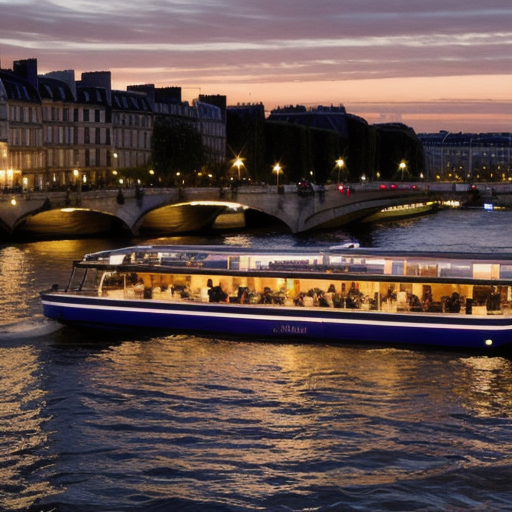

Displayed: images/batch_1/image_1.png


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Image saved as 'images/batch_1/image_2.png'


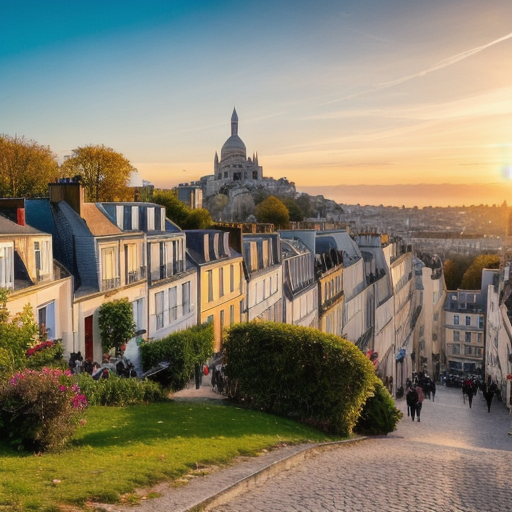

Displayed: images/batch_1/image_2.png


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Image saved as 'images/batch_2/image_3.png'


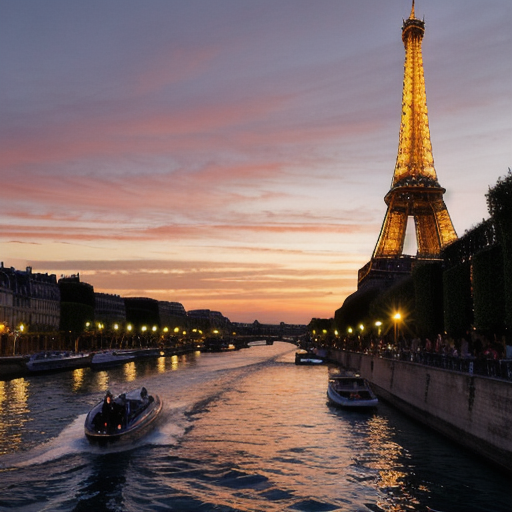

Displayed: images/batch_2/image_3.png


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Image saved as 'images/batch_2/image_4.png'


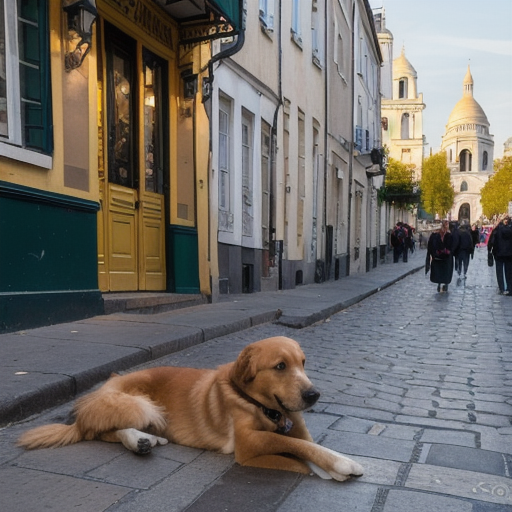

Displayed: images/batch_2/image_4.png


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Image saved as 'images/batch_3/image_5.png'


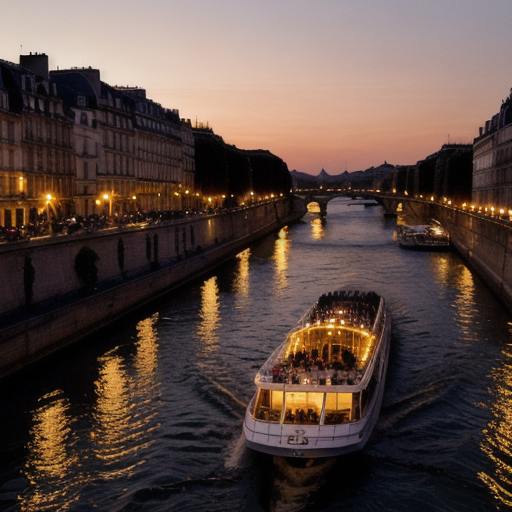

Displayed: images/batch_3/image_5.png


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Image saved as 'images/batch_3/image_6.png'


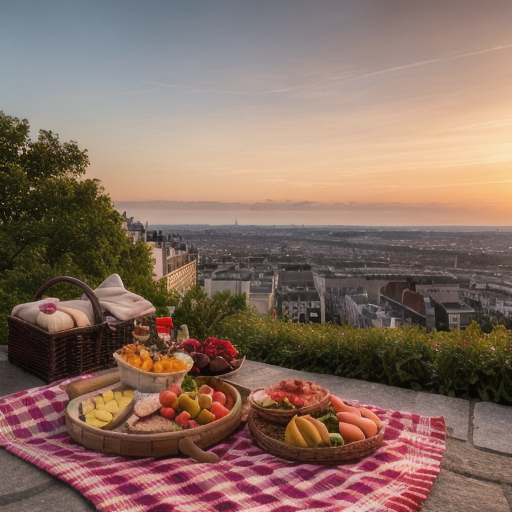

Displayed: images/batch_3/image_6.png


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Image saved as 'images/batch_4/image_7.png'


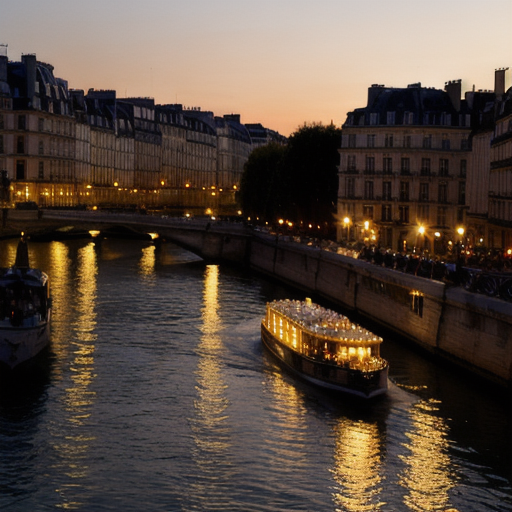

Displayed: images/batch_4/image_7.png


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Image saved as 'images/batch_4/image_8.png'


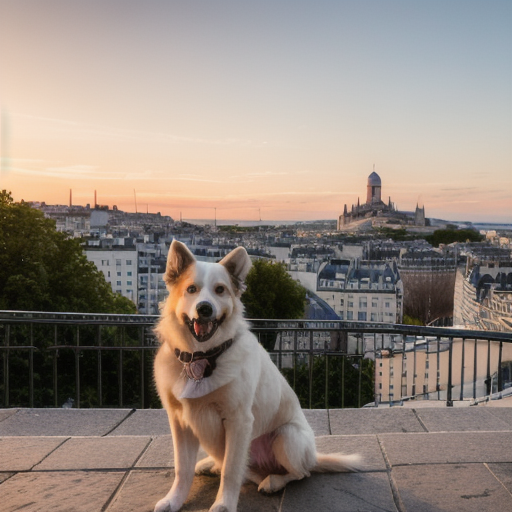

Displayed: images/batch_4/image_8.png
All images saved in 'images'.


In [ ]:
if __name__ == "__main__":
    model_name = "stabilityai/stable-diffusion-xl-base-1.0"
    save_images_to_batches(prompt_array, model_name, output_dir="images")


In [ ]:
!git config --global user.email "ifytrez96@gmail.com"
!git config --global user.name "Trezie"


In [ ]:
!git clone https://github.com/Trezie/Travel.git


fatal: destination path 'Travel' already exists and is not an empty directory.


In [ ]:
!cp /content/Travel-images-diffuser-SG161222/Realistic_Vision.ipynb /content/Travel.git

cp: cannot stat '/content/Travel-images-diffuser-SG161222/Realistic_Vision.ipynb': No such file or directory


In [ ]:
!ls /content


sample_data


In [10]:
import os
print(os.getcwd())


/content


In [9]:
import os
os.listdir()


['.config', 'sample_data']

In [11]:
import os
os.listdir('/content')


['.config', 'sample_data']

In [12]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [13]:
!ls "/content/drive/MyDrive/Colab Notebooks"



'Copy of climate-change-co2'
'Copy of Travel-images-diffuser-SG161222 Realistic_Vision.ipynb'
'Copy of Travel-Vision (1).ipynb'
'Copy of Travel-Vision (2).ipynb'
'Copy of Travel-Vision.ipynb'
'Copy of Untitled4.ipynb'
'Diabetes Analysis.ipynb'
 Travel-images-diffuser.ipynb
 Travel-Vision.ipynb
 Untitled
 Untitled0.ipynb
'Untitled (1)'
 Untitled10.ipynb
 Untitled1.ipynb
 Untitled2.ipynb
 Untitled3.ipynb
 Untitled4.ipynb
 Untitled5.ipynb
 Untitled6.ipynb
 Untitled7.ipynb
 Untitled8.ipynb
 Untitled9.ipynb
 Xray_data4.ipynb
 Xray_model_modified


In [14]:
!cp "/content/drive/MyDrive/Colab Notebooks/Travel-Vision.ipynb" /content/


In [15]:
!ls /content


drive  sample_data  Travel-Vision.ipynb


In [16]:
from google.colab import files
files.download("Travel-Vision.ipynb")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>